**UNZIPPING THE DATASET**

In [1]:
!wget https://dicom5c.blob.core.windows.net/public/Data.zip
!unzip Data.zip


Streaming output truncated to the last 5000 lines.
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1_mask.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_19951217_1_mask.tif  
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_17_mask.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_19951217_17_mask.tif  
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_16_mask.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_19951217_16_mask.tif  
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_24_mask.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_19951217_24_mask.tif  
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_25_mask.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_19951217_25_mask.tif  
  inflating: Data/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_11.tif  
  inflating: __MACOSX/Data/TCGA_DU_5855_19951217/._TCGA_DU_5855_1

**DISPLAYING SAMPLE MRI IMAGES**

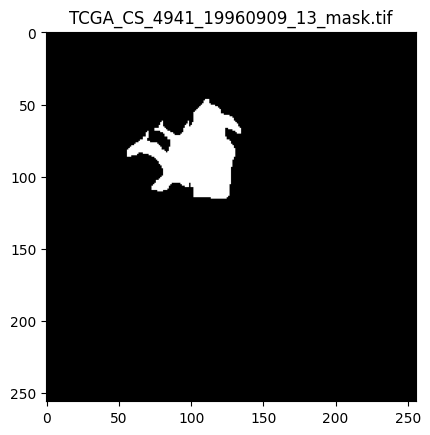

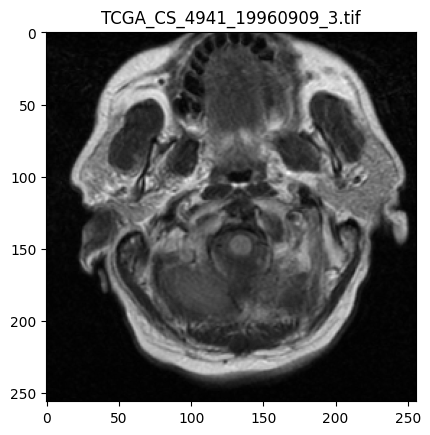

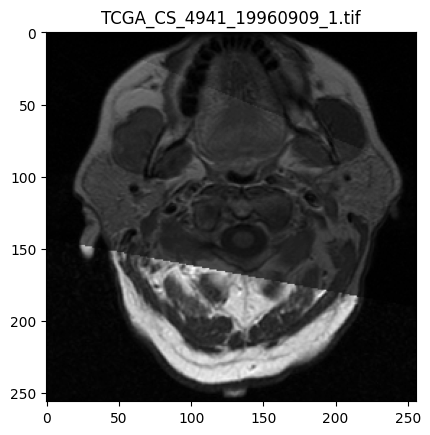

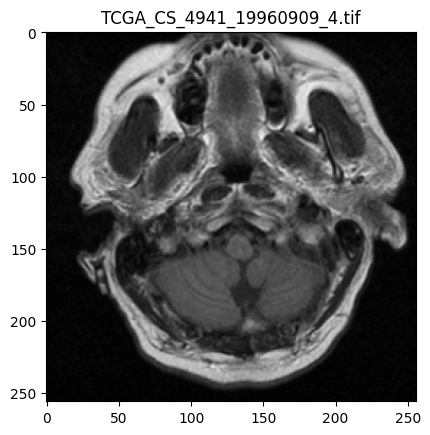

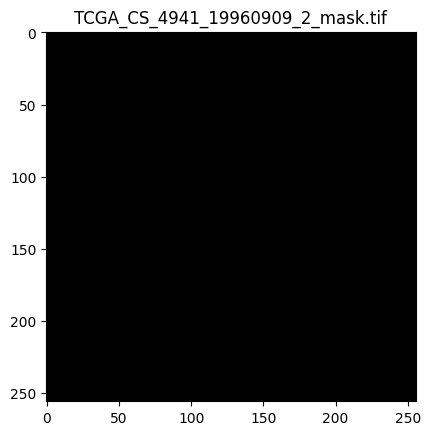

In [16]:
!pip install opencv-python

import cv2
import matplotlib.pyplot as plt
import os
image_folder = '/content/Data/TCGA_CS_4941_19960909'

for filename in os.listdir(image_folder)[:5]:
      filepath = os.path.join(image_folder, filename)
      image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
      plt.imshow(image, cmap='gray')
      plt.title(filename)
      plt.show()

**1. Data Preprocessing**

Implement CLAHE (Contrast Limited Adaptive Histogram Equalization) preprocessing on the MRI images to enhance metastasis visibility.Ensure proper normalization and augmentation of the dataset, considering the specific challenges of metastasis segmentation.

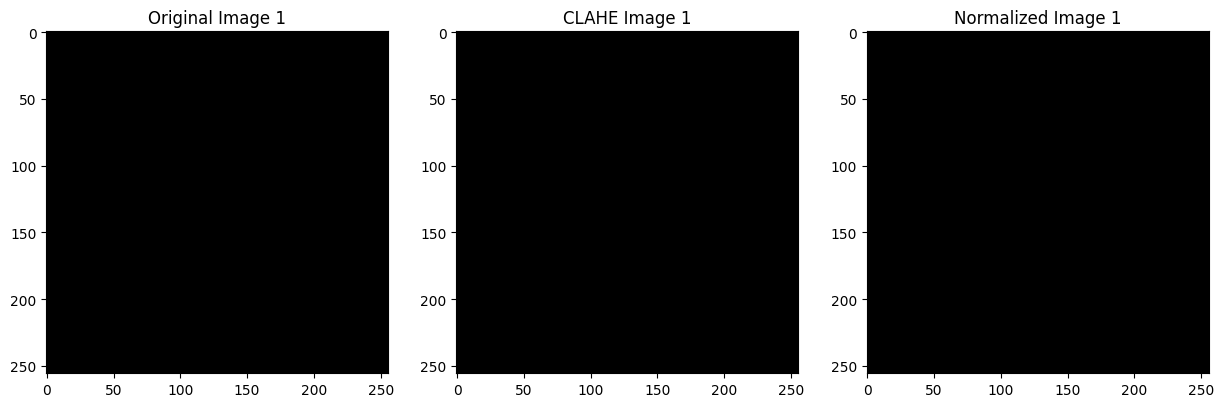

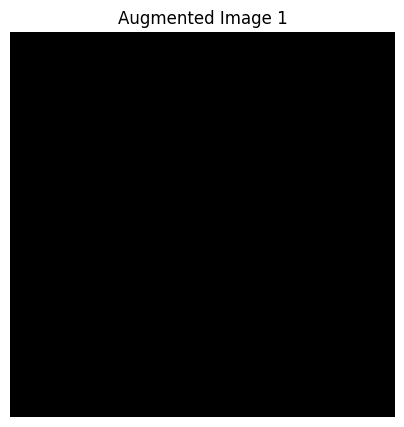

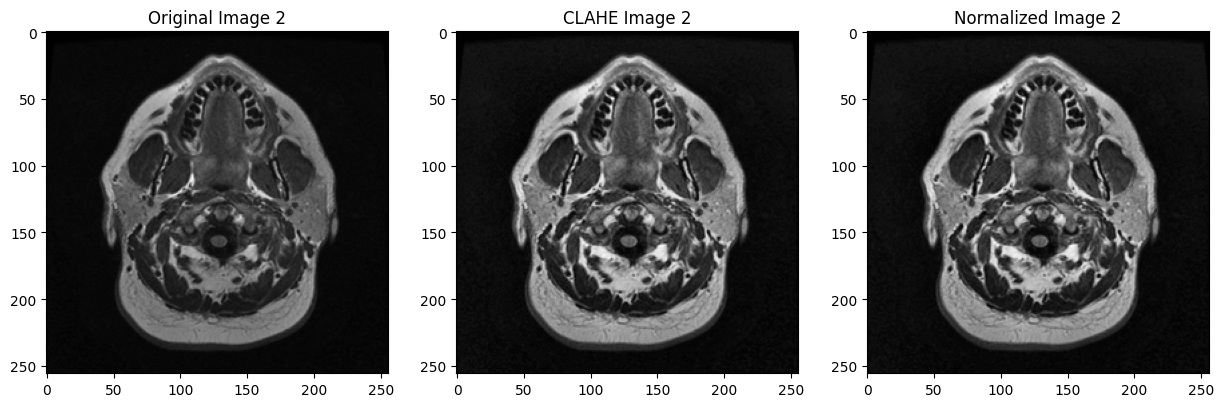

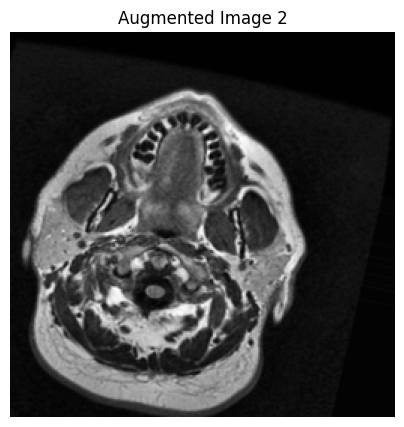

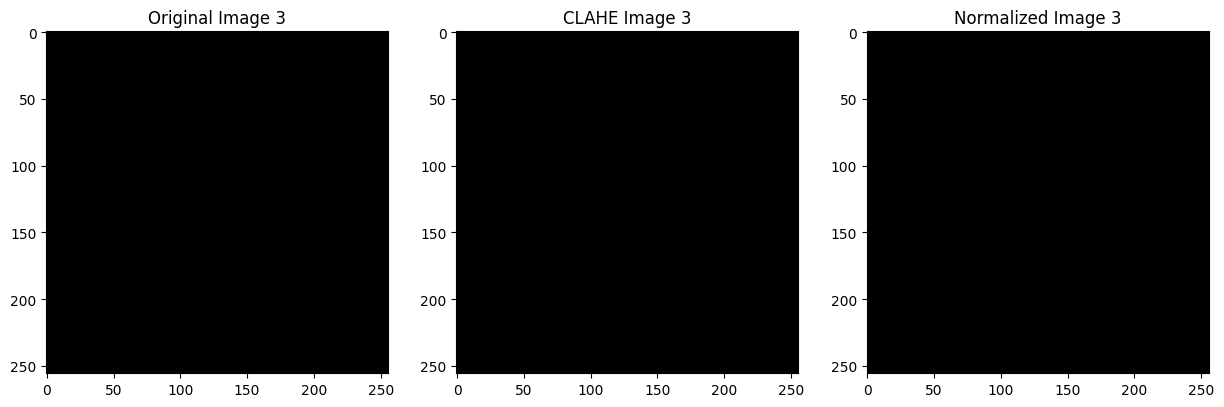

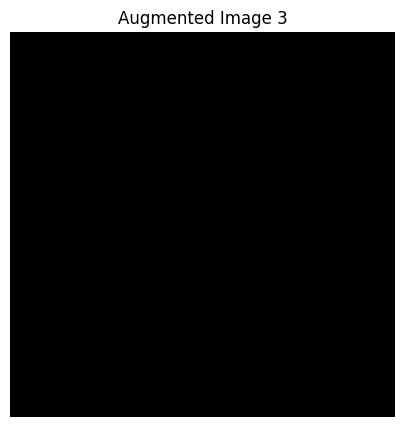

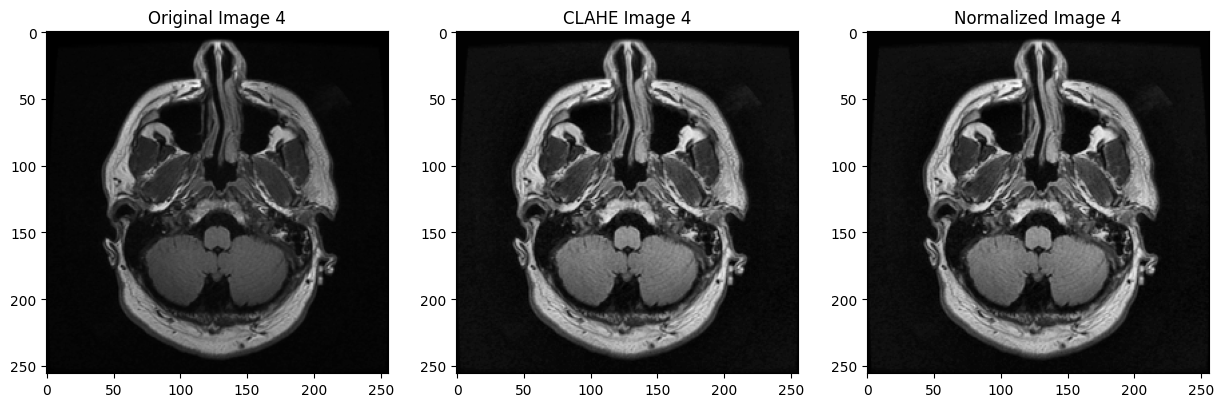

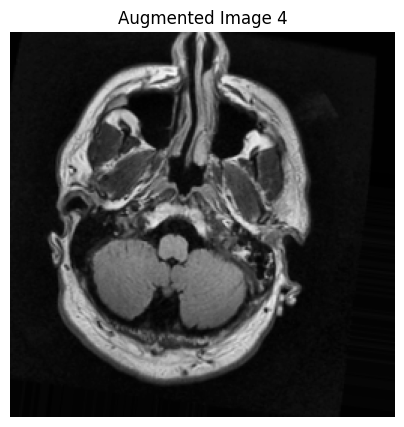

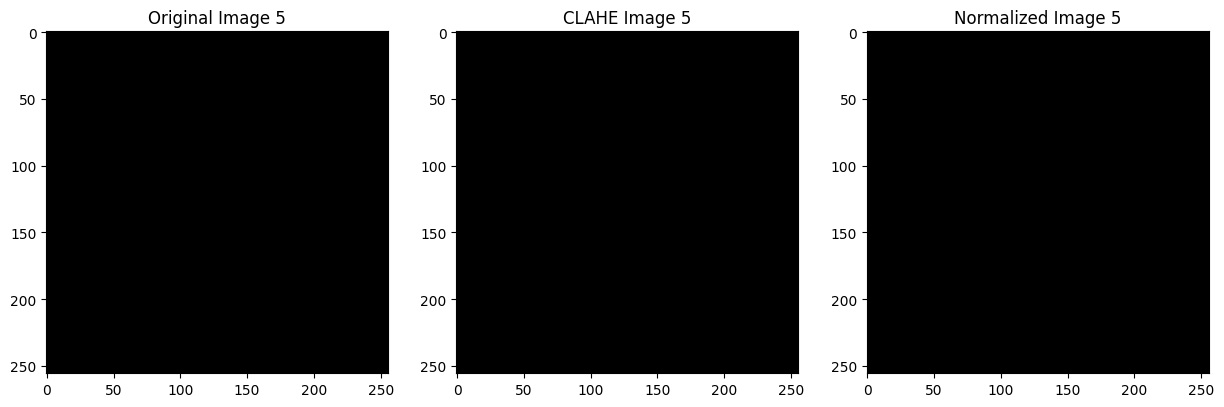

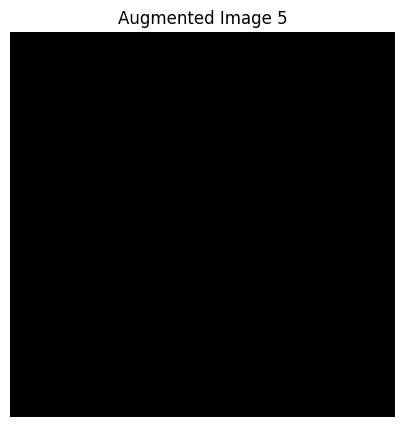

In [29]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_folder = '/content/Data'

def normalize_image(image):
    return image / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

processed_images = []
augmented_images = []

for root, _, files in os.walk(image_folder):
    for filename in files:
        if filename.endswith(".tif"):
            filepath = os.path.join(root, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(image)

            normalized_image = normalize_image(enhanced_image)

            processed_images.append((image, enhanced_image, normalized_image))

            image_array = np.expand_dims(normalized_image, axis=0)
            image_array = np.expand_dims(image_array, axis=-1)

            for augmented_image in datagen.flow(image_array, batch_size=1):
                augmented_images.append(augmented_image[0])
                break

for i in range(min(5, len(processed_images))):
    original_image, clahe_image, normalized_image = processed_images[i]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original Image {i+1}')

    plt.subplot(1, 3, 2)
    plt.imshow(clahe_image, cmap='gray')
    plt.title(f'CLAHE Image {i+1}')

    plt.subplot(1, 3, 3)
    plt.imshow(normalized_image, cmap='gray')
    plt.title(f'Normalized Image {i+1}')

    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_images[i], cmap='gray')
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')
    plt.show()


**Model Implementation**

 Nested U-Net (U-Net++)

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def nested_unet(input_shape=(256, 256, 1), num_classes=1):
    inputs = Input(input_shape)

    conv11 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv11)

    conv21 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv21)

    conv31 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv31)

    conv41 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv41)

    conv51 = conv_block(pool4, 1024)

    up61 = UpSampling2D(size=(2, 2))(conv51)
    merge61 = concatenate([conv41, up61], axis=3)
    conv61 = conv_block(merge61, 512)

    up71 = UpSampling2D(size=(2, 2))(conv61)
    merge71 = concatenate([conv31, up71], axis=3)
    conv71 = conv_block(merge71, 256)

    up81 = UpSampling2D(size=(2, 2))(conv71)
    merge81 = concatenate([conv21, up81], axis=3)
    conv81 = conv_block(merge81, 128)

    up91 = UpSampling2D(size=(2, 2))(conv81)
    merge91 = concatenate([conv11, up91], axis=3)
    conv91 = conv_block(merge91, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv91)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
model = nested_unet()
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 512)    │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 15,682,561 (59.82 MB)

 Trainable params: 15,676,673 (59.80 MB)

 Non-trainable params: 5,888 (23.00 KB)

 **Model Training and Evaluation**

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

def load_data(data_folder):
    images = []
    for root, _, files in os.walk(data_folder):
        for filename in files:
            if filename.endswith(".tif"):
                filepath = os.path.join(root, filename)
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                images.append(image)
    return np.array(images)

def normalize_images(images):
    return images / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def nested_unet(input_shape=(256, 256, 1), num_classes=1):
    inputs = Input(input_shape)

    conv11 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv11)

    conv21 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv21)

    conv31 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv31)

    conv41 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv41)

    conv51 = conv_block(pool4, 1024)

    up61 = UpSampling2D(size=(2, 2))(conv51)
    merge61 = concatenate([conv41, up61], axis=3)
    conv61 = conv_block(merge61, 512)

    up71 = UpSampling2D(size=(2, 2))(conv61)
    merge71 = concatenate([conv31, up71], axis=3)
    conv71 = conv_block(merge71, 256)

    up81 = UpSampling2D(size=(2, 2))(conv71)
    merge81 = concatenate([conv21, up81], axis=3)
    conv81 = conv_block(merge81, 128)

    up91 = UpSampling2D(size=(2, 2))(conv81)
    merge91 = concatenate([conv11, up91], axis=3)
    conv91 = conv_block(merge91, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv91)

    model = Model(inputs=inputs, outputs=outputs)
    return model

data_folder = '/content/Data'
X = load_data(data_folder)

if len(X) == 0:
    raise ValueError("No images found. Please check your folder structure.")

X = normalize_images(X)

augmented_images = []
for img in X:
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    for augmented_image in datagen.flow(img_array, batch_size=1):
        augmented_images.append(augmented_image[0])
        break

augmented_images = np.array(augmented_images)

X_train, X_val = train_test_split(augmented_images, test_size=0.2, random_state=42)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Create dummy labels
Y_train = np.zeros_like(X_train)
Y_val = np.zeros_like(X_val)

model = nested_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))


In [1]:

import tensorflow as tf

class DiceScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(DiceScoreCallback, self).__init__()
        self.X_val, self.y_val = validation_data
        self.best_dice_score = 0.0

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        dice_score = self.calculate_dice_score(self.y_val, y_pred)
        print(f"\nDice Score (Validation): {dice_score:.4f}")
        if dice_score > self.best_dice_score:
            self.best_dice_score = dice_score
            self.model.save("best_model_dice.h5")

    def calculate_dice_score(self, y_true, y_pred):
        smooth = 1e-6
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)